In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import uproot 
import awkward as ak
from pathlib import Path

from typing import Dict, List 
import re
import pickle
from tqdm import tqdm

This note book uses the BDT trained for EB3 and test the score on Forward/Central

# Apply to data with eta label to show Forward/Central

## Read data

In [2]:
data_path = '/global/cfs/projectdirs/atlas/hrzhao/qgcal/BDT_EPEML/pkls_etalabel/all_JZs_format2.pkl'
with open(data_path, 'rb') as f:
    data = pickle.load(f)

columns = [*data['JZ4'].columns]
n_features = 5
column_names = ["jet_pt", "jet_eta", "jet_nTracks", "jet_trackWidth", "jet_trackC1", "jet_trackBDT", "jet_PartonTruthLabelID", "total_weight"]


empty_list = []
for key, data_JZ in tqdm(data.items()):
    empty_list.append(data_JZ.drop(columns=['event']))

pd_all = pd.concat(empty_list)

pd_array = pd_all.to_numpy()
jets_array = pd_array.reshape((int(len(pd_array)*2), -1))
assert jets_array.shape[-1] == 10 

100%|██████████| 7/7 [00:02<00:00,  2.49it/s]


## Read BDT model

In [3]:
bdt_path = './models/bdt_model_flat_pt_gridsearchCV.model'
with open(bdt_path, 'rb') as f:
    bdt = pickle.load(f)

In [4]:
bdt

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=9,
                                                         max_features='log2',
                                                         min_samples_leaf=0.001),
                   learning_rate=0.1, n_estimators=1000)

In [5]:
y_mc16A = bdt.decision_function(jets_array[:, :n_features])

In [6]:
np.save('y_mc16A.npy', y_mc16A)

## Plot new response

### Inclusive Quark vs Gluon

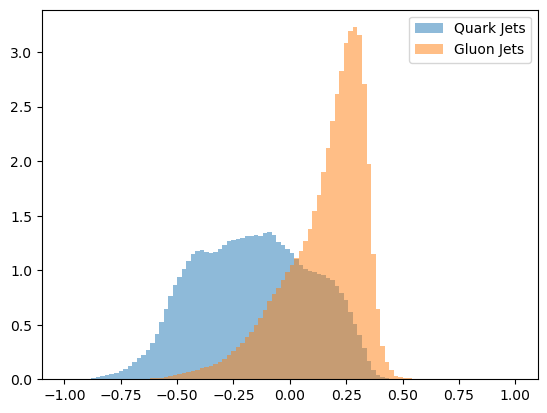

In [7]:
bdt_bins = np.linspace(-1, 1, 101)
quark_idx = np.where(jets_array[:, -1] ==0)[0]
gluon_idx = np.where(jets_array[:, -1] ==1)[0]

fig, ax = plt.subplots()
ax.hist(y_mc16A[quark_idx], weights=jets_array[quark_idx,-3], bins=  bdt_bins, alpha = 0.5,label='Quark Jets', density=True)
ax.hist(y_mc16A[gluon_idx], weights=jets_array[gluon_idx,-3], bins=  bdt_bins, alpha = 0.5,label='Gluon Jets', density=True)
ax.legend()
plt.show()

### Quark vs Gluon in pt bins

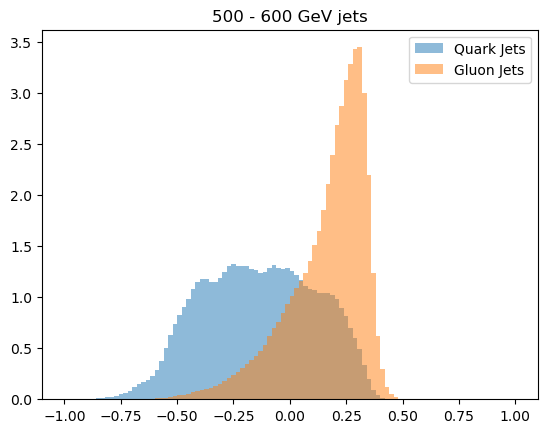

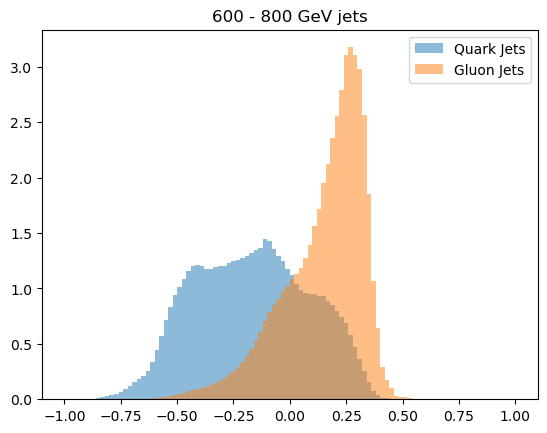

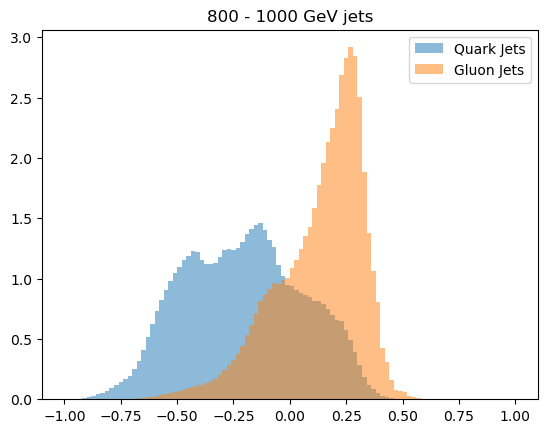

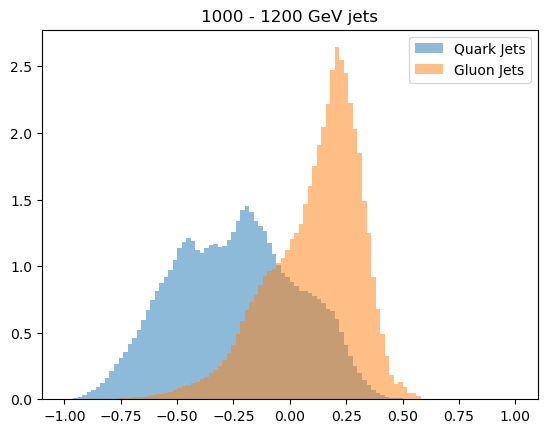

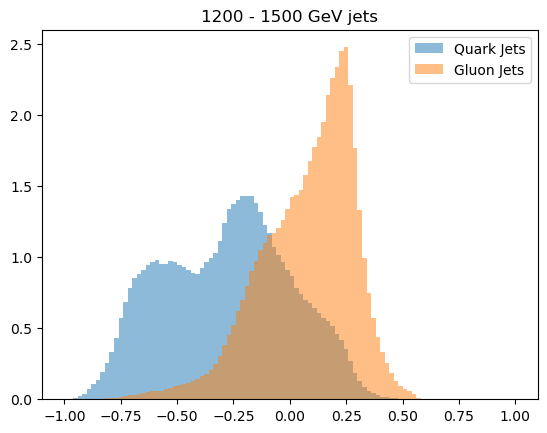

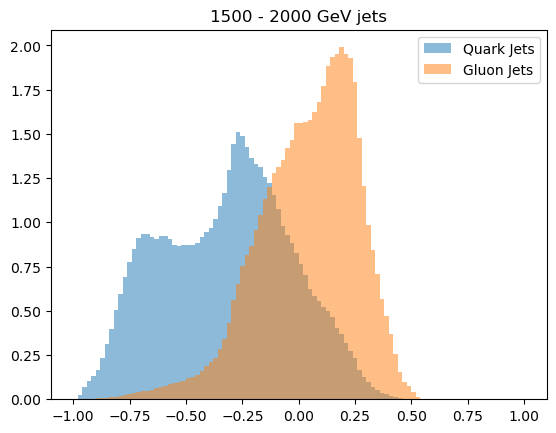

In [11]:
label_ptrange = np.array([500, 600, 800, 1000, 1200, 1500, 2000])
pt_binned_jets_idx = np.digitize(jets_array[:,0], bins=label_ptrange)
for i, pt in enumerate(label_ptrange[:-1]):
    jets_at_pt_idx = np.where(pt_binned_jets_idx-1 == i)
    jets_at_pt = jets_array[jets_at_pt_idx]
    gluon_idx = np.where(jets_at_pt[:, -1] ==1)[0]
    quark_idx = np.where(jets_at_pt[:, -1] ==0)[0]
    fig, ax = plt.subplots()
    ax.hist(y_mc16A[jets_at_pt_idx][quark_idx], weights=jets_at_pt[quark_idx,-3], bins =  bdt_bins, alpha = 0.5, label='Quark Jets', density = True)
    ax.hist(y_mc16A[jets_at_pt_idx][gluon_idx], weights=jets_at_pt[gluon_idx,-3], bins =  bdt_bins, alpha = 0.5, label='Gluon Jets', density = True)
    ax.legend()
    ax.set_title(f"{pt} - {label_ptrange[i+1]} GeV jets")
    plt.plot()

### Inclusive Forward vs Central

[]

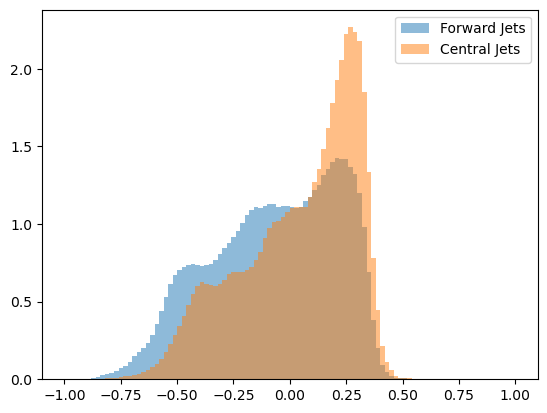

In [8]:
forward_idx = np.where(jets_array[:, -2] ==1)[0]
central_idx = np.where(jets_array[:, -2] ==0)[0]
fig, ax = plt.subplots()
ax.hist(y_mc16A[forward_idx], weights=jets_array[forward_idx,-3], bins =  bdt_bins, alpha = 0.5, label='Forward Jets', density = True)
ax.hist(y_mc16A[central_idx], weights=jets_array[central_idx,-3], bins =  bdt_bins, alpha = 0.5, label='Central Jets', density = True)
ax.legend()
plt.plot()

### Forward vs Central in pt bins

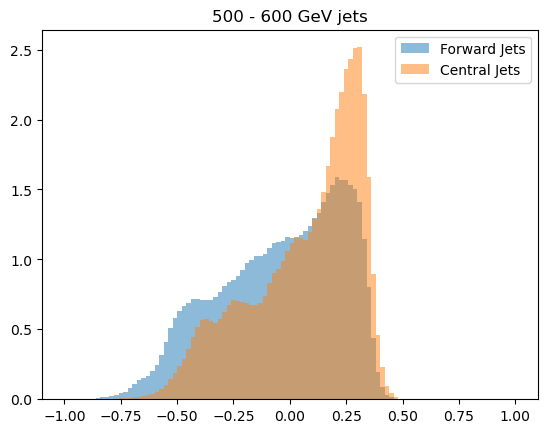

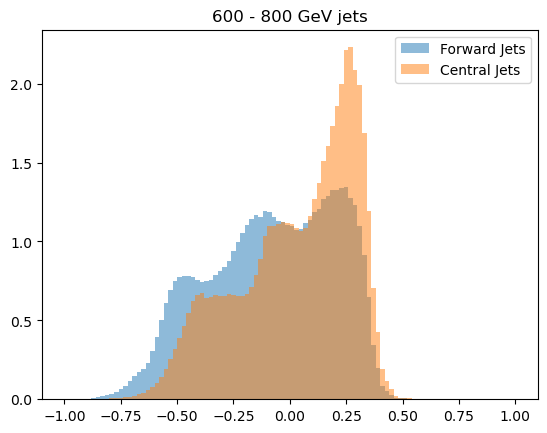

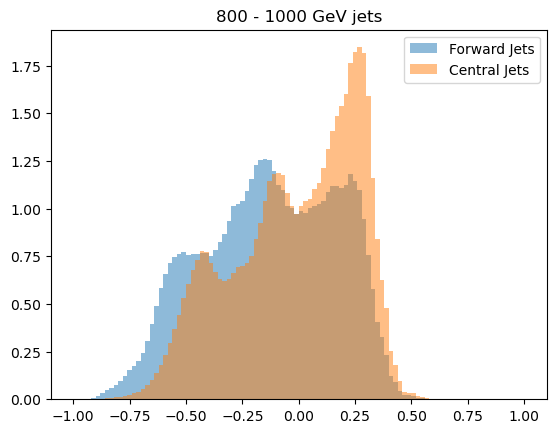

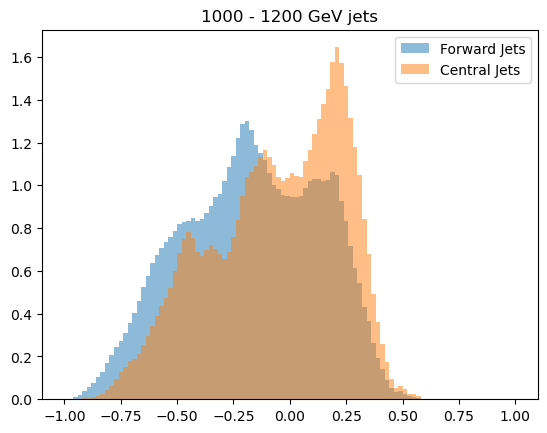

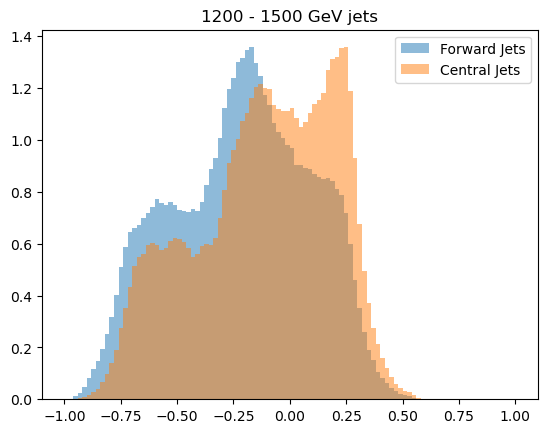

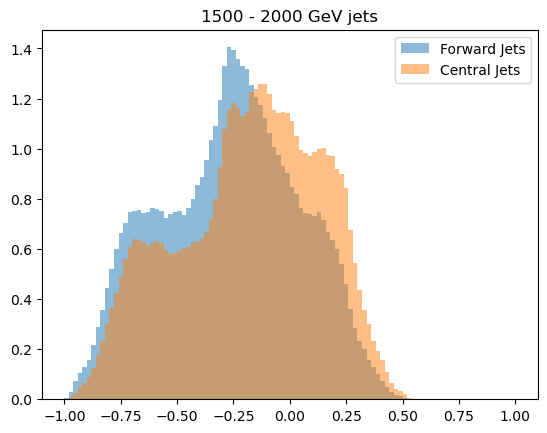

In [12]:
label_ptrange = np.array([500, 600, 800, 1000, 1200, 1500, 2000])
pt_binned_jets_idx = np.digitize(jets_array[:,0], bins=label_ptrange)
for i, pt in enumerate(label_ptrange[:-1]):
    jets_at_pt_idx = np.where(pt_binned_jets_idx-1 == i)
    jets_at_pt = jets_array[jets_at_pt_idx]
    forward_idx = np.where(jets_at_pt[:, -2] ==1)[0]
    central_idx = np.where(jets_at_pt[:, -2] ==0)[0]
    fig, ax = plt.subplots()
    ax.hist(y_mc16A[jets_at_pt_idx][forward_idx], weights=jets_at_pt[forward_idx,-3], bins =  bdt_bins, alpha = 0.5, label='Forward Jets', density = True)
    ax.hist(y_mc16A[jets_at_pt_idx][central_idx], weights=jets_at_pt[central_idx,-3], bins =  bdt_bins, alpha = 0.5, label='Central Jets', density = True)
    ax.legend()
    ax.set_title(f"{pt} - {label_ptrange[i+1]} GeV jets")
    plt.plot()

### Forward/Central Q/G components

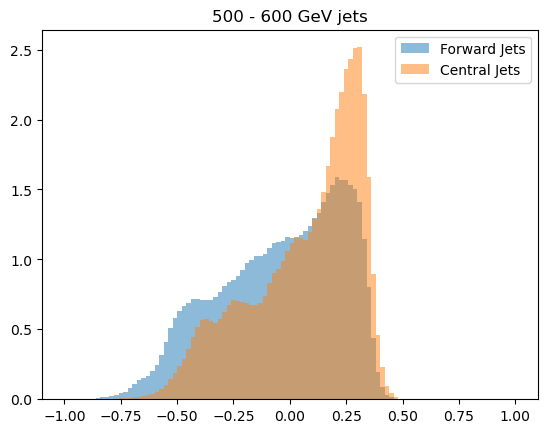

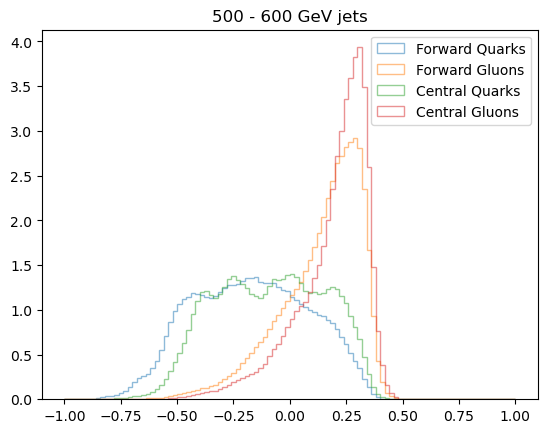

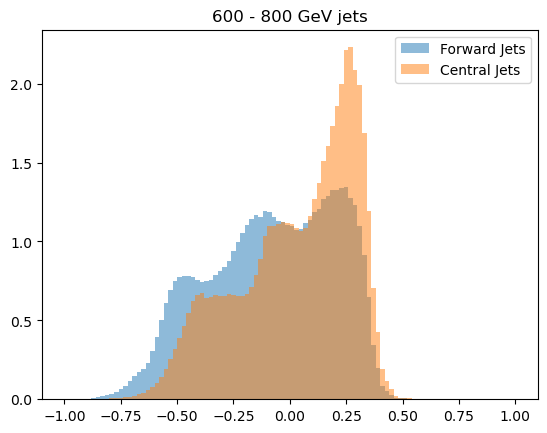

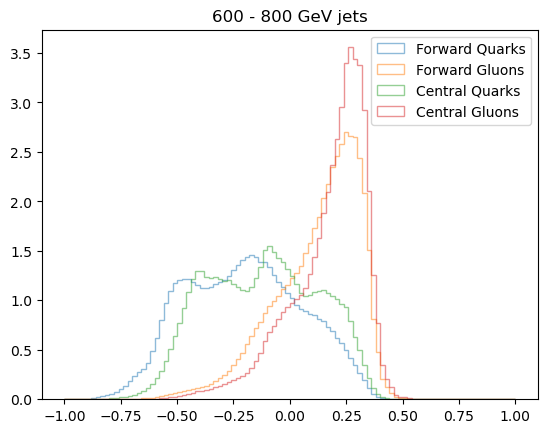

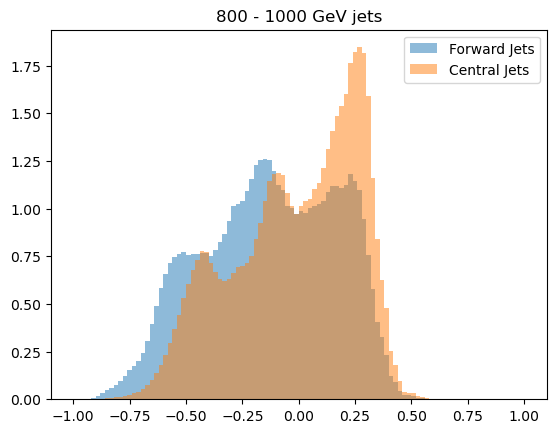

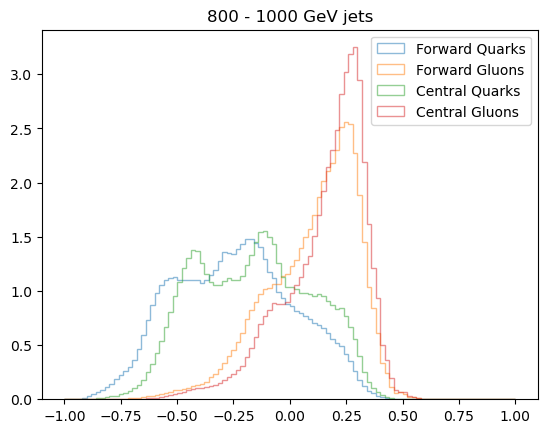

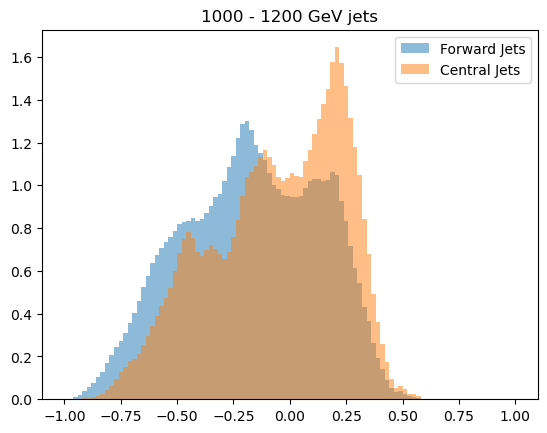

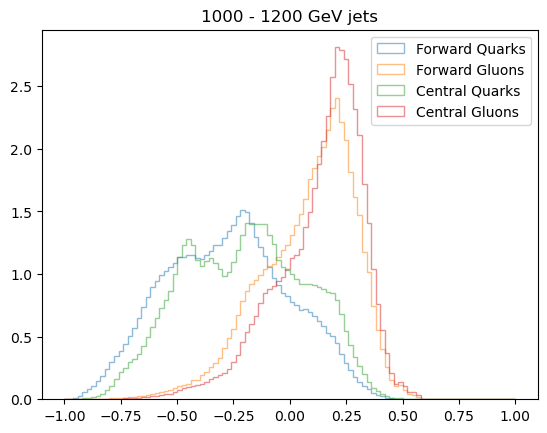

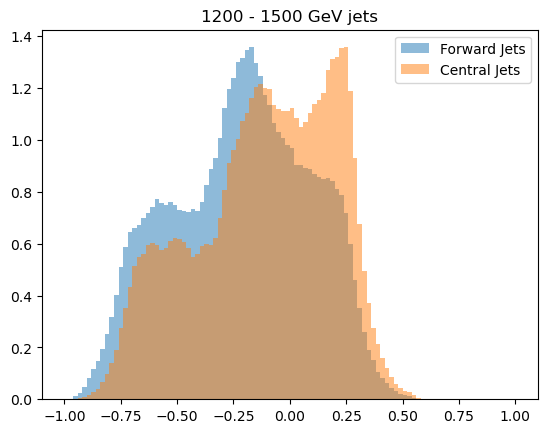

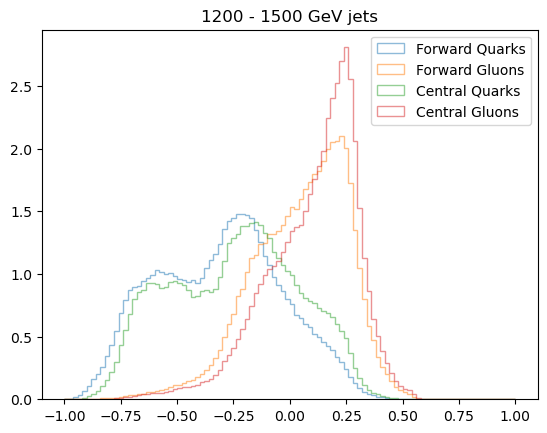

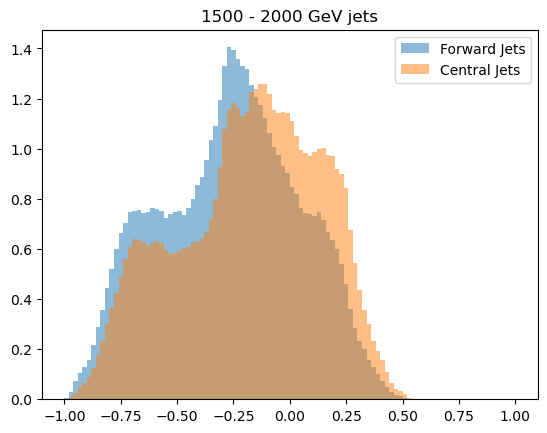

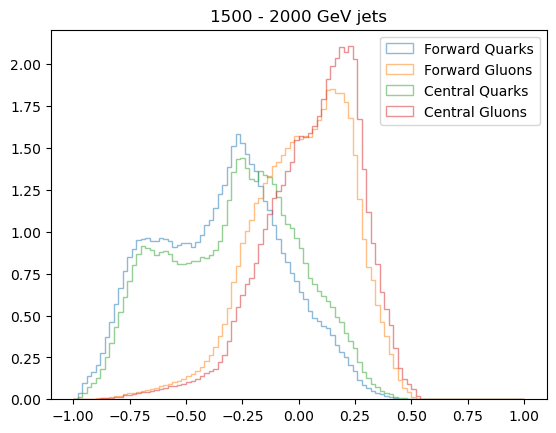

In [14]:
for i, pt in enumerate(label_ptrange[:-1]):
    jets_at_pt_idx = np.where(pt_binned_jets_idx-1 == i)
    jets_at_pt = jets_array[jets_at_pt_idx]
    forward_idx = np.where(jets_at_pt[:, -2] ==1)[0]
    central_idx = np.where(jets_at_pt[:, -2] ==0)[0]

    forward_jets = jets_at_pt[forward_idx]
    central_jets = jets_at_pt[central_idx]


    forward_quark_idx = np.where(forward_jets[:, -1] == 0)[0]
    forward_gluon_idx = np.where(forward_jets[:, -1] == 1)[0]
    central_quark_idx = np.where(central_jets[:, -1] == 0)[0]
    central_gluon_idx = np.where(central_jets[:, -1] == 1)[0]

    fig, ax = plt.subplots()
    ax.hist(y_mc16A[jets_at_pt_idx][forward_idx], weights=forward_jets[:, -3], bins =  bdt_bins, alpha = 0.5, label='Forward Jets', density = True)
    ax.hist(y_mc16A[jets_at_pt_idx][central_idx], weights=central_jets[:, -3], bins =  bdt_bins, alpha = 0.5, label='Central Jets', density = True)
    ax.legend()
    ax.set_title(f"{pt} - {label_ptrange[i+1]} GeV jets")
    plt.plot()


    fig, ax = plt.subplots()
    ax.hist(y_mc16A[jets_at_pt_idx][forward_idx][forward_quark_idx], weights=forward_jets[:, -3][forward_quark_idx], bins =  bdt_bins, alpha = 0.5, label='Forward Quarks', density = True, histtype='step')
    ax.hist(y_mc16A[jets_at_pt_idx][forward_idx][forward_gluon_idx], weights=forward_jets[:, -3][forward_gluon_idx], bins =  bdt_bins, alpha = 0.5, label='Forward Gluons', density = True, histtype='step')
    ax.hist(y_mc16A[jets_at_pt_idx][central_idx][central_quark_idx], weights=central_jets[:, -3][central_quark_idx], bins =  bdt_bins, alpha = 0.5, label='Central Quarks', density = True, histtype='step')
    ax.hist(y_mc16A[jets_at_pt_idx][central_idx][central_gluon_idx], weights=central_jets[:, -3][central_gluon_idx], bins =  bdt_bins, alpha = 0.5, label='Central Gluons', density = True, histtype='step')
    ax.legend()
    ax.set_title(f"{pt} - {label_ptrange[i+1]} GeV jets")
    plt.plot()
